## Import libraries

In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, Add, GRU

np.random.seed(42)
tf.random.set_seed(42)

2021-10-03 16:36:16.709539: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-03 16:36:16.709650: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load source datasets

In [2]:
train_df = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [3]:
test_df = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


## Feature Engineering

In [4]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-5...Completed")
    
    return df


print("Train data...\n")
train = add_features(train_df)

print("\nTest data...\n")
test = add_features(test_df)

del train_df
del test_df
gc.collect()

Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed


25

In [5]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

In [6]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print(f"train: {train.shape} \ntest: {test.shape} \ntargets: {targets.shape}")

train: (75450, 80, 53) 
test: (50300, 80, 53) 
targets: (75450, 80)


## Hardware config

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

2021-10-03 16:37:45.787630: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-03 16:37:45.790692: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-03 16:37:45.790729: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-03 16:37:45.790756: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f62ae18beaf1): /proc/driver/nvidia/version does not exist
2021-10-03 16:37:45.793932: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU: grpc://10.0.0.2:8470
Batch Size: 512


## Keras DNN Model

In [8]:
def dnn_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=256, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=128, return_sequences=True))(x3)
    
    z2 = Bidirectional(GRU(units=256, return_sequences=True))(x2)
    z3 = Bidirectional(GRU(units=128, return_sequences=True))(Add()([x3, z2]))
    z4 = Bidirectional(GRU(units=64, return_sequences=True))(Add()([x4, z3]))
    
    x = Concatenate(axis=2)([x4, z2, z3, z4])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [9]:
model = dnn_model()
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 53)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 80, 1536)     5050368     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 1024)     8392704     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 80, 512)      2623488     bidirectional_1[0][0]            
__________________________________________________________________________________________

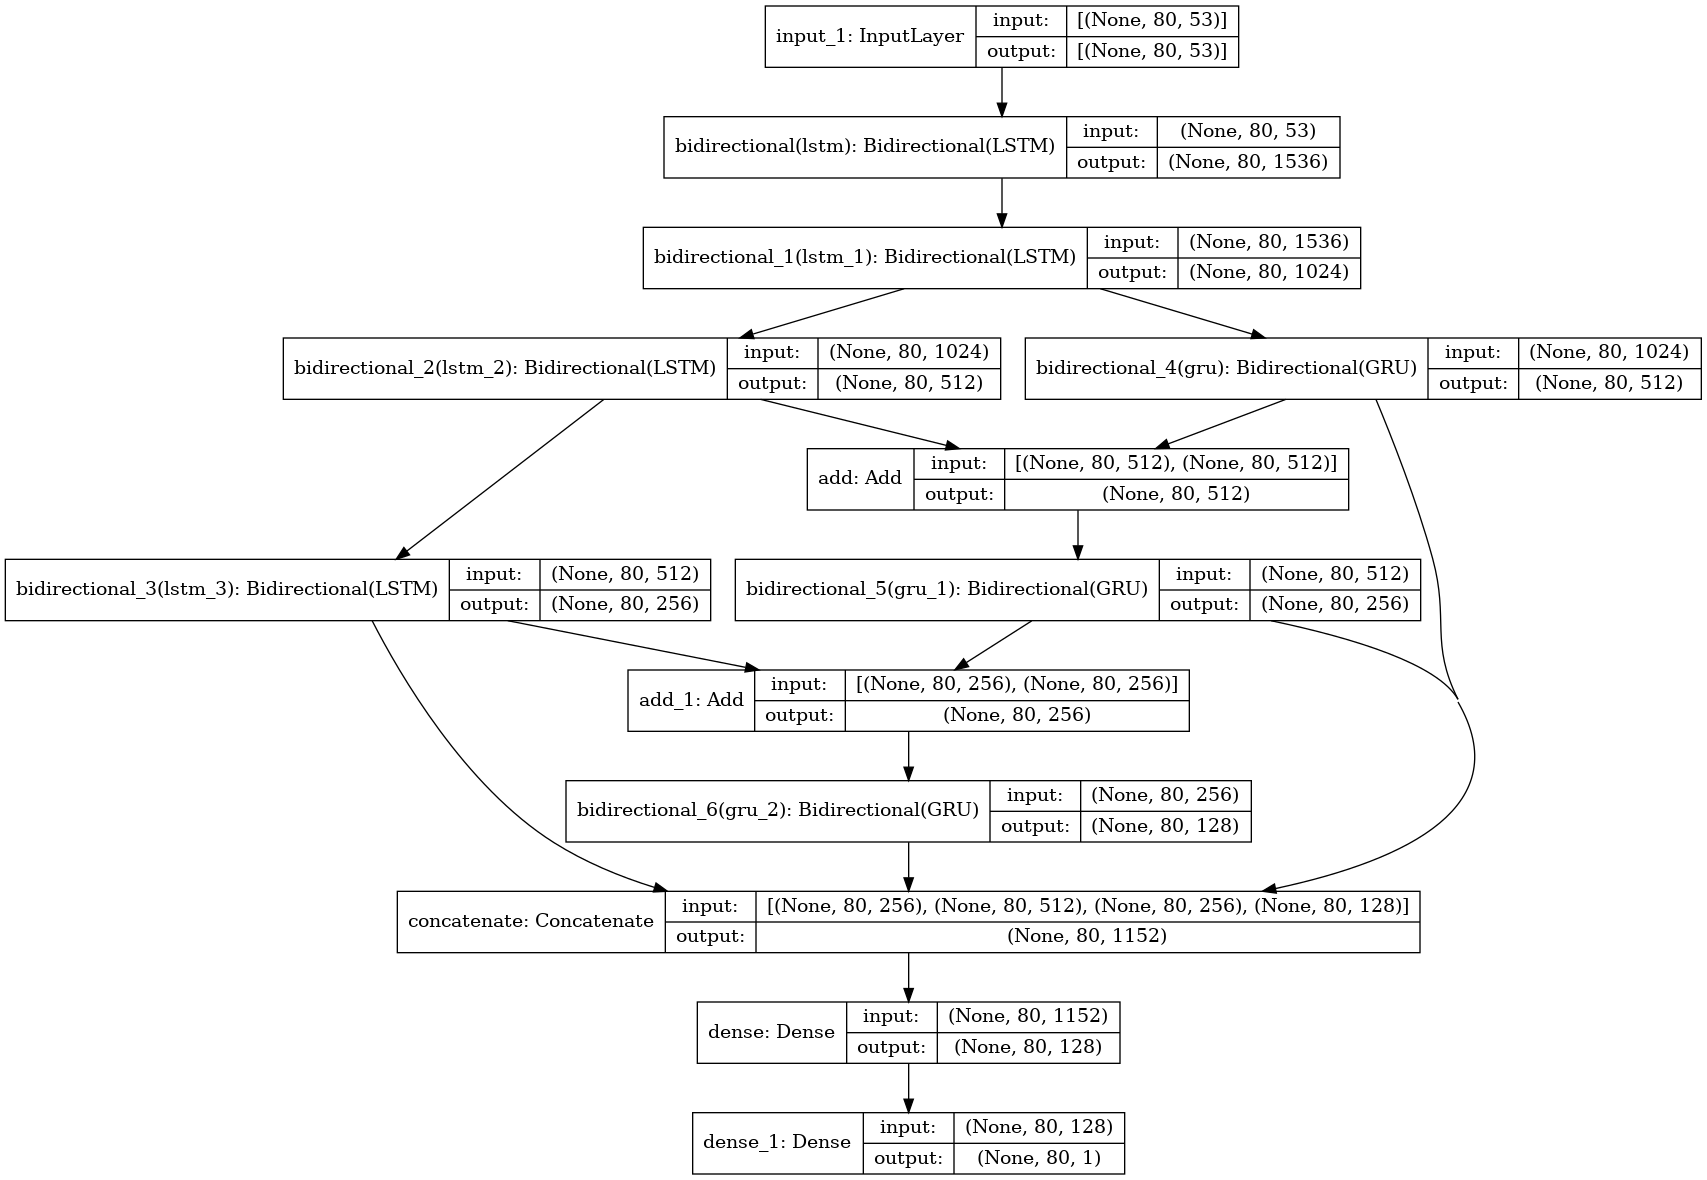

In [10]:
plot_model(
    model, 
    to_file='Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [11]:
with tpu_strategy.scope():
    
    VERBOSE = 0
    test_preds = []
    kf = KFold(n_splits=5, shuffle=True, random_state=2021)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        model = dnn_model()
        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                               patience=10, verbose=VERBOSE)
        
        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        chk_point = ModelCheckpoint(f'./Bidirect_LSTM_model_{fold+1}C.h5', options=save_locally, 
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=50, 
                           verbose=VERBOSE, mode="min", 
                           restore_best_weights=True)
        
        model.fit(X_train, y_train, 
                  validation_data=(X_valid, y_valid), 
                  epochs=300,
                  verbose=VERBOSE,
                  batch_size=BATCH_SIZE, 
                  callbacks=[lr, chk_point, es])
        
        load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
        model = load_model(f'./Bidirect_LSTM_model_{fold+1}C.h5', options=load_locally)
        
        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        score = mean_absolute_error(y_true, y_pred)
        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

2021-10-03 16:38:18.930075: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1023705600 exceeds 10% of free system memory.


Fold-1 | OOF Score: 0.1667908410512076


2021-10-03 17:25:03.528758: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 853088000 exceeds 10% of free system memory.
2021-10-03 17:25:24.160850: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1023705600 exceeds 10% of free system memory.


Fold-2 | OOF Score: 0.17194944667643997


2021-10-03 18:12:40.171647: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 853088000 exceeds 10% of free system memory.
2021-10-03 18:13:03.587351: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1023705600 exceeds 10% of free system memory.


Fold-3 | OOF Score: 0.16554549519061032
Fold-4 | OOF Score: 0.1680878634276525
Fold-5 | OOF Score: 0.16805484442003488


## Create submission file

In [12]:
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
submission["pressure"] = sum(test_preds)/5
submission.to_csv('submission.csv', index=False)